**сеть Кохонена (SOM, самоорганизующиеся карты Кохонена)**

решение задачи кластеризации

_Евгений Борисов <esborisov@sevsu.ru>_

---

Борисов Е.С.  Кластеризатор на основе нейронной сети Кохонена.   
http://mechanoid.su/neural-net-kohonen-clusterization.html

Kohonen, T. Learning Vector Quantization, Neural Networks, 1988, 1 (suppl 1), 303.

Kohonen, T.  The Self-Organizing Map.   
https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1990-Kohonen-PIEEE.pdf

Горбаченко В.И.  Сeти Кохонена.  
https://masters.donntu.org/2018/fknt/shumskyi/library/article8.pdf

Нестандартная кластеризация 4: Self-Organizing Maps, тонкости, улучшения, сравнение с t-SNE.    
https://habr.com/ru/post/338868/

---

In [1]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

# np.set_printoptions(precision=3,suppress=True)

---

In [2]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

## данные

In [3]:
from sklearn.datasets import make_blobs

n_samples = 500
n_clusters = 17 # количество кластеров

X,_ = make_blobs( 
        n_samples=n_samples,
        n_features=2,
        centers=n_clusters,  
        cluster_std=rng.uniform(size=n_clusters)+.7
    )
X.shape

(500, 2)

In [4]:
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler().fit_transform(X)

del X

## модель

каждый нейрон первого (распределительного) слоя    
соединен со всеми нейронами второго (выходного) слоя,  
которые расположены в виде двумерной решетки.

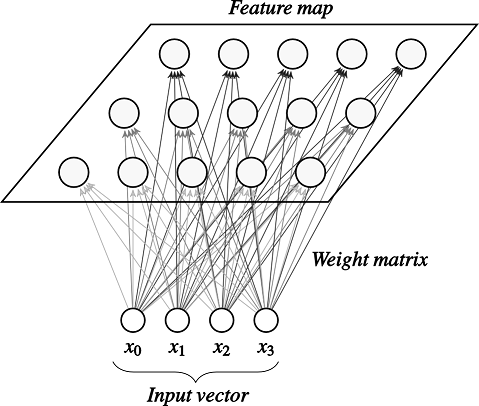

https://www.liveinternet.ru/community/rss_rss_hh_full/post418940841/

соединения нейронов выходного слоя могут иметь разную топологию, (это не обязательно двумерная решетка)

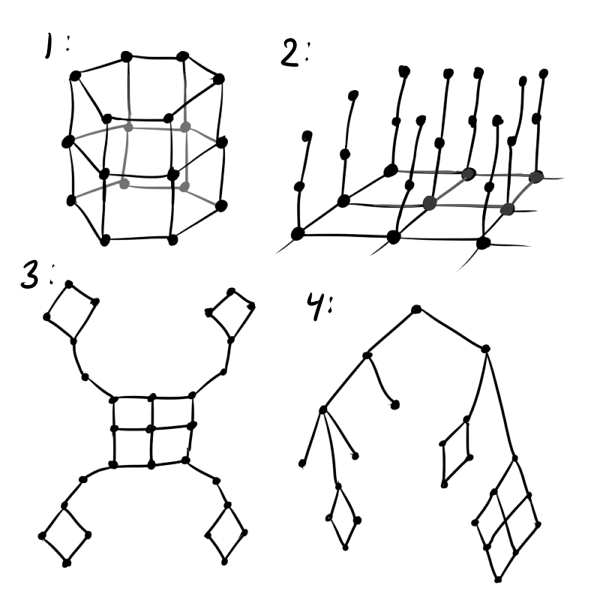

https://habr.com/ru/post/338868/


SOM решает задачу векторного квантования,   
которая состоит в наилучшей аппроксимации всей совокупности векторов данных $X$    
ограниченным набором кодовых векторов $W$.

состояние нейрона
$$s = \|x,w\| $$

In [5]:
# евклидово расстояние 

from sklearn.metrics.pairwise import euclidean_distances

def state(x,w): # состояние нейронов
    return euclidean_distances(x,w)

def score(x,w): 
    s = state(x,w)
    return np.argmin(s, axis=1), s

def predict(x,w): 
    return np.argmin( state(x,w), axis=1)

### инициализация параметров сети

In [59]:
from itertools import product

# # инициализация параметров сети
grid_size=(7,7)

# накрываем данные сеткой
lim = np.vstack([ X_train.min(axis=0),X_train.max(axis=0)])
weight = np.array(list(product(
    np.linspace(*lim[:,0],grid_size[0]),
    np.linspace(*lim[:,1],grid_size[1])
)))*.85

weight.shape

(49, 2)

In [60]:
# weight = rng.uniform(size=(np.prod(grid_size),2))
# weight.shape

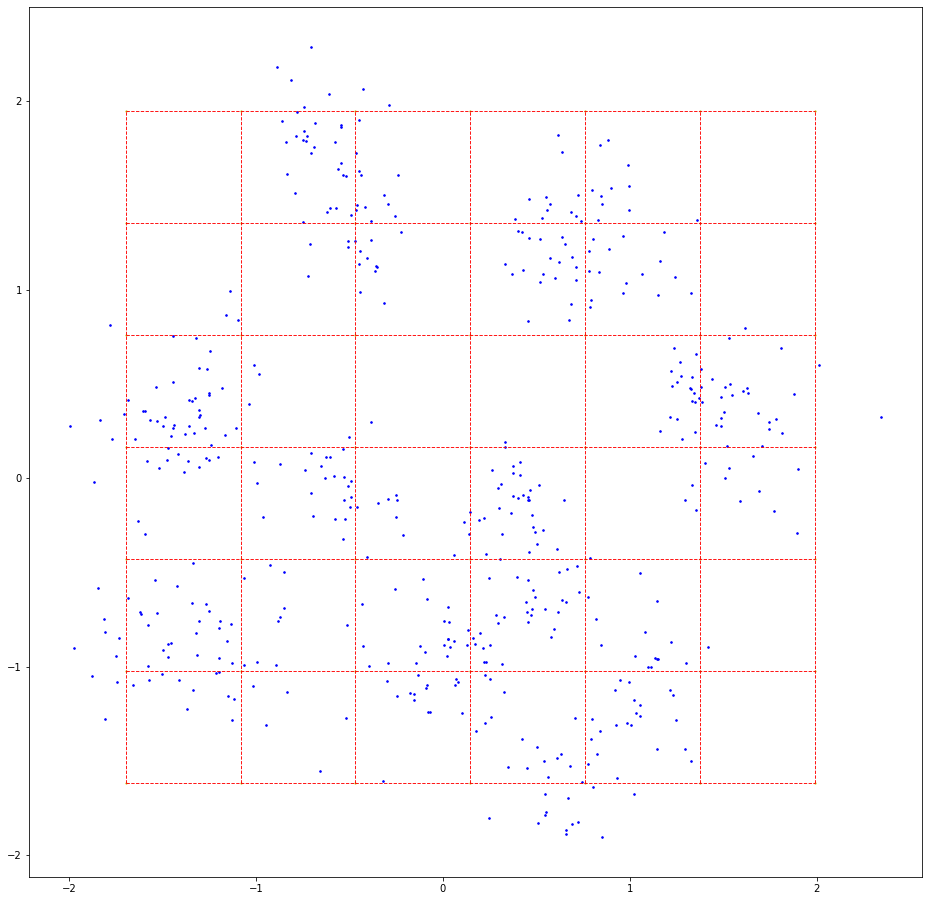

In [61]:
def plot_map_2d(weight,grid_size,ax):    
    r,c = grid_size
    w = weight.reshape(grid_size+(2,))
    for i in range(r): ax.plot(w[i,:,0],w[i,:,1],color='r',linestyle='dashed',linewidth=.9)
    for j in range(c): ax.plot(w[:,j,0],w[:,j,1],color='r',linestyle='dashed',linewidth=.9)
    ax.scatter(x=weight[:,0],y=weight[:,1],marker='.',color='y',s=5)

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot()
plt.scatter(X_train[:,0],X_train[:,1],s=10,marker='.',color='b')
plot_map_2d(weight,grid_size,ax)  


## обучение

### функция окрестности

In [62]:
def gauss(d,s=.1): # функция окрестности
    return np.exp(-np.square(d)/s)

Text(0.5, 1.0, 'функция окрестности')

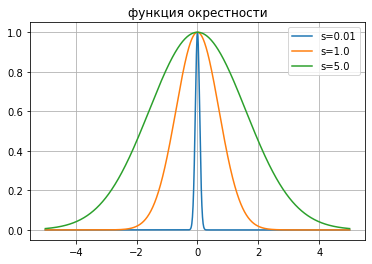

In [63]:
d = np.linspace(-5,5,1000)
plt.plot(d,gauss(d,s=.01),label='s=0.01')
plt.plot(d,gauss(d,s=1.),label='s=1.0')
plt.plot(d,gauss(d,s=5.),label='s=5.0')
plt.grid()
plt.legend()
plt.title('функция окрестности')

In [64]:
# место (i,j) нейрона n в двумерной решетке
def number2indices(n,grid_size):
    return np.vstack([ np.unravel_index(i,grid_size) for i in n ])

# расстояние между нейронами n1 и n2 в двумерной решетке
def distance_on_map(n1,n2,grid_size):
    i1 = number2indices(n=n1,grid_size=grid_size)
    i2 = number2indices(n=n2,grid_size=grid_size)
    return np.abs( i1[:,np.newaxis,:] - i2[np.newaxis, :, :] ).max(axis=-1)

# векторы расстояний от ка ждого нейрона до всех остальных нейронов двумерной решетки
def distance_on_map_all(grid_size):
    n = list(range(np.prod(grid_size)))
    return distance_on_map(n,n,grid_size)

# grid_distance = distance_on_map_all(grid_size)

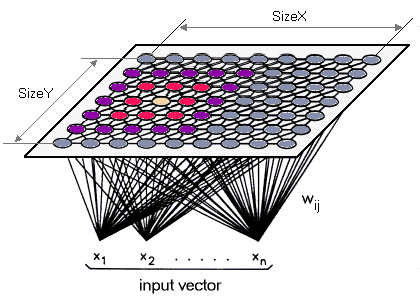

In [65]:
# коэффициенты окрестности для нейронов номер [n1,n2,...]
def neighbor_score(n,sig,grid_distance):
    return gauss( grid_distance[n,:], s=sig )

# neighbor_score([1,2,3],sig=.5)

### изменение весов

изменение весов

$$
\Delta w = \eta\cdot \theta(k) \cdot (x − w)
$$


$\eta \in (0,1)$ - шаг обучения   

$k$ - номер нейрона-победителя

$\theta(k)_{j} \in [0,1]$ - значение ф-ции окрестности нейрона-победителя $k$ для нейрона $j$;


In [66]:
def get_batch(x,batch_size):
    n_samples = len(x) # количество учебных пар
    batch_count = np.ceil( n_samples/batch_size).astype(int) # количество батчей
    # перемешиваем учебный набор и режем его на батчи
    for idx in np.array_split(rng.permutation(n_samples), batch_count ):
        yield x[idx,:]

In [67]:
def fit_batch(x,w,lr,sig,grid_distance):
    # определяем выходной нейрон-победитель
    winner,s = score(x,w) 

    # значение функции окрестности нейрона-победителя для всех выходных нейронов
    nb = neighbor_score(winner,sig=sig,grid_distance=grid_distance)  

    # изменение весов
    dw = ((x[:,np.newaxis,:]-w[np.newaxis,:,:])*nb[:,:,np.newaxis]).mean(axis=0)

    return w+lr*dw

In [68]:
def fit_epoch(x,weight,lr,sig,grid_distance,batch_size): # эпоха обучения
    weight_ = weight.copy()
    for xb in get_batch(x,batch_size): # для всех точек учебного датасета
        weight_ = fit_batch( xb, weight_, lr, sig, grid_distance) # подстраиваем веса
    return weight_

In [69]:
def msqe(a,b): # среднее квадратичное отклонение
    return np.square(a-b).mean()

In [70]:
def input_variance(x,weight): # среднее отклонение входа от вектора весов победителя
    win = predict(x,weight)
    return np.mean([ msqe(weight[c], x[win==c]) for c in set(win) ])

В начале процедуры настройки всем нейронам конкурирующего слоя присваивается одинаковый параметр активности

In [71]:
# grid_size = (101,101) # размеры решетки выходного слоя
# weight = weight_init(input_size=X_train.shape[1],output_size=grid_size)
weight0 = weight.copy()

In [72]:
# np.linspace(grid_size)

In [73]:
lr = .5 # скорость обучения
lr_step = .99 # шаг уменьшения скорости обучения
lr_min = .09 # минимальная скорость обучения

# параметр размера окрестности для нейрона-победителя
sig = np.sqrt(len(weight[1])).astype(int) 
sig_step = .85 # шаг уменьшения размера окрестности
sig_min = .01 # минимальное значение параметра размера окрестности

dw_history = [] # история отклонения весов
inp_var_history = [] # история изменения среднего отклонения входа от вектора весов победителя
lr_history = [] # история изменения скорости обучения
sig_history = [] # история изменения размера окрестности для нейрона-победителя

weight_var_min = 9e-6 # минимально существенное отклонение весов

# размер одного пакета учебных данных
#batch_size = len(X_train)//10 
batch_size = 5

# векторы расстояний от каждого нейрона до всех остальных нейронов двумерной решетки
grid_distance = distance_on_map_all(grid_size)

In [74]:
from tqdm import tqdm

In [75]:
%%time 

n_epoch = 2000 # количество циклов обучения


epoch = tqdm(range(n_epoch))
for i in epoch:
    w = weight.copy() # сохраняем старые значения весов
    
    # шаг обучения модели
    weight = fit_epoch(X_train,weight,lr,sig,grid_distance,batch_size) 
       
    dw_history.append(msqe(weight[0],w)) # считаем отклонение весов
    
    inp_var_history.append( input_variance(X_train,weight) )
    
    epoch.set_postfix({'weight var':dw_history[-1],'inp var':inp_var_history[-1],'lr':lr,'sig':sig,})
    lr= max(lr*lr_step,lr_min) # уменьшаем скорость обучения
    sig = max(sig*sig_step,sig_min) # уменьшаем размер окрестности нейрона-победителя

    lr_history.append(lr) # история изменения скорости обучения
    sig_history.append(sig) # история изменения размера окрестности для нейрона-победителя
    
#     if dw_history[-1]<weight_var_min: # если нет существенного изменения весов...
#         print('low weight variance detected')
#         break # ... то выходим
        
#     if var_history[-1]<var_min:
#         print('low variance detected')
#         break

100%|██████████| 2000/2000 [00:34<00:00, 57.95it/s, weight var=2.83, inp var=0.0114, lr=0.09, sig=0.01] 

CPU times: user 34.9 s, sys: 1.59 s, total: 36.5 s
Wall time: 34.5 s


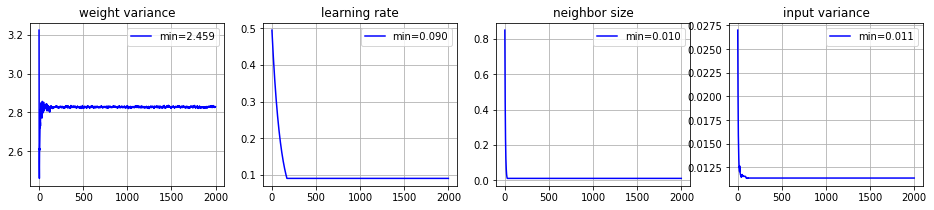

In [76]:
history = {
'weight variance':dw_history,
'learning rate':lr_history,
'neighbor size':sig_history,
'input variance': inp_var_history,
}

fig,ax = plt.subplots(1,len(history),figsize=(16,3))
for i,t in enumerate(history):
    ax[i].plot(history[t],c='b',label='min=%.3f'%min(history[t]))
    ax[i].grid()
    ax[i].legend()
    ax[i].set_title(t)

## тестируем

In [77]:
p = predict(X_train,weight)

In [78]:
print( 'clusters:', len(set(p)) )

clusters: 48


In [79]:
from scipy.spatial import ConvexHull

def hull_2d(x,ax):
    if len(x)<3: return
    hull = ConvexHull(x) # рисуем выпуклую оболочку вокруг кластера
    v = np.append( hull.vertices, hull.vertices[0] ) # замыкаем оболочку
    ax.plot(x[v,0],x[v,1],'--',lw=.5,c='b')

def plot_2d(X,p,clusters,colors,ax):
    for c in clusters: 
        #ax.scatter( x=X[p==c,0], y=X[p==c,1], s=10, marker='.',c=[colors[clusters[c]]])
        ax.scatter( x=X[p==c,0], y=X[p==c,1], s=10, marker='.',color='g')
        hull_2d(X[p==c,:2],ax)
    ax.grid()

        
def plot(X,p,weight,grid_size,figsize=(10,10)):
    #n_feature = X.shape[1]
    clusters = { c:i for i,c in enumerate(sorted(set(p)))}
    colors = rng.uniform(size=(len(clusters),3),low=.0,high=1.)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    plot_2d(X,p,clusters,colors,ax)  
    plot_map_2d(weight,grid_size,ax)

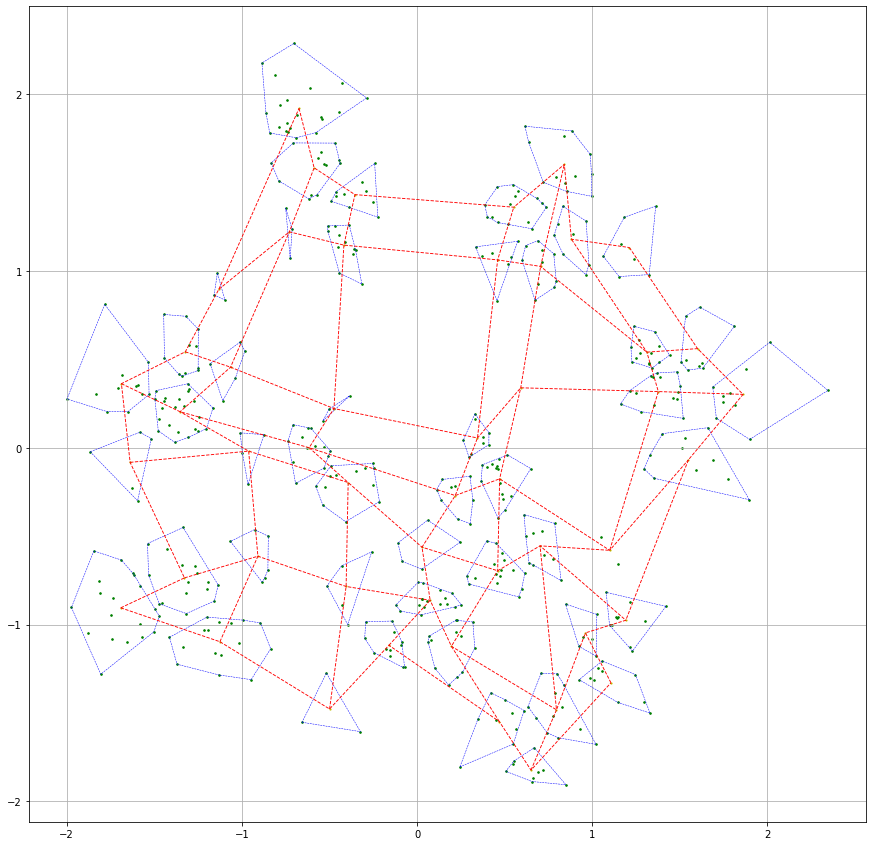

In [80]:
plot(X_train,p,weight,grid_size,figsize=(15,15))

In [84]:
# оценка результата
from sklearn.metrics import silhouette_score

# clusters = { c:i for i,c in enumerate(sorted(set(p)))}
# c = np.vectorize(lambda c:clusters[c])(p)

# отношение внутрикластерного и межкластерного расстояний
silhouette_score(X_train,p)

0.34768876141607324

In [85]:
def arr2img(x):
    x_min,x_max = x.min(),x.max()
    d = (x_max-x_min)
    d = d if d>0. else 1.
    return np.floor(((x-x_min)/d)*254).astype(np.int)   

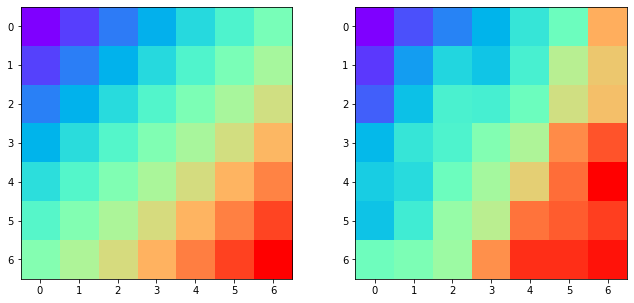

In [86]:
n_feature = X_train.shape[1]

im0 = weight0.mean(axis=-1).reshape(grid_size)
im1 = weight.mean(axis=-1).reshape(grid_size)
cmap='rainbow'    
    
fig,ax = plt.subplots(1,2,figsize=(11,5))
ax[0].imshow( arr2img( im0), cmap=cmap )
ax[1].imshow( arr2img( im1), cmap=cmap )

---

In [ ]:
# dm = distance_on_map_all(grid_size)
# gauss( grid_distance, s=2. )[:,:5]
# n_all = list(range(np.prod(grid_size)))
# dm = distance_on_map(n_all,n_all,grid_size).shape
# dm

In [ ]:
# # для каждого элемента двумерной решетки вычислим значение ф-ции окрестности
# map_size = 9
# grid_size = (map_size,map_size)

# m = np.array(range(map_size*map_size))
# m.reshape(grid_size)

In [ ]:
# np.prod(grid_size)

In [ ]:
# i1 = number2indices(n=[9,4],s=grid_size)
# i2 = number2indices(n=[19,34,42],s=grid_size)
# np.abs( i1[:,np.newaxis,:] - i2[np.newaxis, :, :] ).max(axis=-1)

# np.sum(np.abs(a[:, None, :] - b[None, :, :]), axis=-1)


# distance_on_map(n1=[19,34],n2=[9,4],s=grid_size)
# winner_distance_on_map(n=[9,4],s=grid_size)
# neighbor_score(n=[9,4],s=(map_size,map_size)).reshape((map_size,map_size)).shape

In [ ]:
# x = next(get_batch(X,len(X)//10))
# sig=.5
# lr=.1
# grid_distance = distance_on_map_all(grid_size)
# activity = np.ones(len(weight[1]))/len(weight[1])

---

In [ ]:
# import plotly.graph_objects as go
# import itertools, math, numpy as np

# from scipy.spatial import ConvexHull

# # This simply creates a set of points:
# n = 3
# m = 3
# E = np.array(list(itertools.product(np.arange(-1, 1.1, .5), repeat=m)))
# V = [
#  [-2.20676418,  1.53670924, -1.5541674 ],
#  [ 0.63437404,  0.07306301,  3.82253086],
#  [ 3.19989112,  0.71987311,  2.79373418]
# ]
# x = np.array([np.dot(V, e) for e in E])

# # Then I compute the convex hull using scipy:
# xc = x[ConvexHull(x).vertices]

# fig = go.Figure()
# fig.add_trace(go.Mesh3d(x=xc[:, 0], 
#                         y=xc[:, 1], 
#                         z=xc[:, 2], 
#                         color="blue", 
#                         opacity=.5,
#                         alphahull=0))

In [ ]:
# # инициализация параметров сети
# def weight_init(input_size,output_size):
#     out_count = np.prod(grid_size) # количество нейронов выходного слоя
#     return [
#         rng.normal(size=(out_count,input_size),scale=.1), # веса
#         np.zeros(out_count), # сдвиги
#     ]

In [ ]:
# map_size = 9
# grid_size = (map_size,map_size)

# weight = weight_init(input_size=X.shape[1],output_size=grid_size)
# # predict(X,weight)

In [ ]:
# np.linspace(size=grid_size)
# np.linspace?

# X,Y = np.mgrid[-5:5.1:0.5, -5:5.1:0.5]

# r = np.linspace(0,1,50)
# c = np.linspace(0,2,100)
# m = np.meshgrid(r,c)

# m[0].shape,m[1].shape


In [ ]:
# [row,col,<features>]

#w = np.zeros(grid_size+(2,))
# w = np.ones(grid_size)[:,:,np.newaxis]*np.linspace((0,1),(0,1),grid_size[0])[np.newaxis,:]

#w[0,:,:] = np.linspace((0,1),(0,1),101)
# w[:,:,0] = np.linspace((0,1),(0,1),101)
#w[:,:,1] = np.linspace(0,1,101)
# w.shape

# np.linspace( (0.,1.), (0.,1.), grid_size[0] )
# grid_size[0]

In [ ]:
# grid_size = (101,101) # размеры решетки выходного слоя
# weight = weight_init(input_size=X_train.shape[1],output_size=grid_size)
# weight0 = weight.copy()

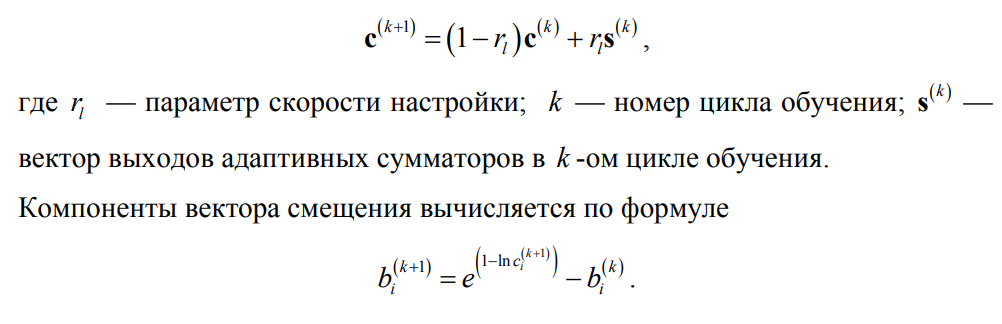